<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_3_SLSTR_coverage.ipynb"><< Determining SLSTR product coverage</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_5_SLSTR_radiance_BT_spectra.ipynb">SLSTR radiance and brightness temperature spectra >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Learn SLSTR: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
  - **<a href="./1_1a_SLSTR_data_access_Data_Store.ipynb" target="_blank">1_1a_SLSTR_data_access_Data_Store.ipynb</a>** (if using the Data Store)
    <br><br>**OR**<br><br>
  - **<a href="./1_1b_SLSTR_data_access_HDA.ipynb" target="_blank">1_1b_SLSTR_data_access_HDA.ipynb</a>** (if using WEkEO)
    
</div>
<hr>

# 1.4 SLSTR bands and imagery

### Data used

| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 SLSTR level-1B | EO:EUM:DAT:0411 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SL_1_RBT___NTC?query=SLSTR&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:SL_1_RBT___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASL_1_RBT___&initial=1" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* How the SLSTR instrument collects data at different wavelengths to characterise the electromagnetic signals from the ocean, land, and atmosphere.
* How to extract the data associated with these wavebands from the SLSTR level-1 product.
* How to combine the data from these different wavebands to create a "false colour" image.
* How these bands can reveal features associated with the sea surface temperature of the oceans.


### Outline

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [SLSTR bands](#section1)
 1. [SLSTR grids](#section2)
 1. [Daytime and night-time imagery](#section3)
 1. [RGB band recipes](#section4)
 1. [Mapping imagery](#section5)
 1. [Applying your knowledge](#section6)

<hr>

In [1]:
# library imports
import cartopy.crs as ccrs
import eumartools
import glob
import inspect
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import warnings
import xarray as xr

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. SLSTR bands
[Back to top](#TOC_TOP)

</div>


SLSTR has nine spectral bands that detect top of atmosphere (TOA) radiation in the visible near-infrared (VNIR), short-wave infrared (SWIR) and thermal infrared (TIR) regions of the electromagnetic region. Bands S1, S2, and S3 are solar reflectance bands in the VNIR with central wavelengths of 555, 659 and 865 nm respectively. These are used for cloud screening, as well as for land and atmospheric composition applications (vegetation monitoring and aerosols). There are three other solar reflectance bands in the SWIR - S4, S5, and S6 with central wavelengths of 1375, 1610, and 2250 respectfully. These are used for further cloud detection, ice and snow, and other vegetation monitoring applications. The TIR bands - S6, S7, and S8 - with central wavelengths of 3740, 10850 and 12000 nm respectively, are used for sea and land surface temperature applications as well as the detection of fires. There are two further bands specifically for fire detection - F1 and F2 - with central wavelenghts of 3740 and 10850 nm respectively. 


<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. SLSTR grids
[Back to top](#TOC_TOP)

</div>

At level-2, all SLSTR products are provided on a single grid. However, at level-1, multiple grids are used. These grids reflect that:
* <font color="#138D75">**SLSTR views in two "dual" geometries**</font>
    * these are labelled as "n" (nadir) and "o" (oblique) in the grid and product names
* <font color="#138D75">**SLSTR has grids at two resolutions**</font>
    * at 500 m, the "a" and "b" stripe grids for the VNIR (S1/S2/S3) and SWIR (S4/S5/S6) solar reflectance bands
    * at 1 km "i" TIR (S7/S8/S9) and "f" FIRE (F1) grids
* <font color="#138D75">**different detectors work on each stripe**</font>
    * VNIR & SWIR (S1-S6) channels are measured on the "a" stripe grid
    * SWIR (S4-S6) channels are also measured on the "b" stripe grid

Consquently, each channel is associated with multiple files, e.g.:

* S4_radiance_**an**.nc - S4 SWIR solar reflectance band on the **"a"**-stripe in the nadir **"n"** view
* S4_radiance_**ao**.nc - S4 SWIR solar reflectance band on the **"a"**-stripe in the oblique **"o"** view
* S4_radiance_**bn**.nc - S4 SWIR solar reflectance band on the **"b"**-stripe in the nadir **"n"** view
* S4_radiance_**bo**.nc - S4 SWIR solar reflectance band on the **"b"**-stripe in the oblique **"o"** view


<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Daytime and night-time imagery
[Back to top](#TOC_TOP)

</div>

SLSTR acquires during the day and at night. The solar reflectance bands, S1-S6, are not available in level-1B products at night. The TIR bands, S7-S9, are always available. 

*Note: the highest quality SST is derived from night-time TIR acquisitions. For the reason why, please see the <a href="./1_6_SLSTR_SST.ipynb" target="_blank">1_6_SLSTR_SST</a> notebook.*

In [3]:
# selecting SAFE directory: ["night-time", "day-time"]
SAFE_directories = [os.path.join(os.getcwd(), 'products', 
    'S3A_SL_1_RBT____20220209T220650_20220209T220950_20220211T045404_0179_082_001_0540_MAR_O_NT_004.SEN3'),
    os.path.join(os.getcwd(), 'products', 
    'S3A_SL_1_RBT____20220209T225750_20220209T230050_20220211T073550_0179_082_001_3600_MAR_O_NT_004.SEN3')]

In [4]:
grid_reduce = 3

In [5]:
# read all the bands from our products: nadir and a-stripe
solar_channels = [1,2,3,4,5,6]
TIR_channels = [7,8,9]

band_dict = {}
for SAFE_directory, time_of_day in zip(SAFE_directories, ["night", "day"]):
    print(f" ---- Reading {time_of_day} product ----")
    band_dict[time_of_day] = {}
    for pattern, bands_needed, flag_file, flag_var in zip(['S*radiance_an.nc', 'S*BT_in.nc'], 
                                                     [solar_channels, TIR_channels],
                                                     ["flags_an.nc", "flags_in.nc"],
                                                     ["confidence_an", "confidence_in"]):
        band_files = glob.glob(os.path.join(SAFE_directory, pattern))
        band_vars = xr.open_mfdataset(band_files)

        # read variables
        for band_var in band_vars:
            band_num = int(band_var.split('_')[0][1])
            if band_num in bands_needed and "exception" not in band_var and "orphan" not in band_var:
                print(f"Reading:  {band_var}")
                band_dict[time_of_day][band_var] = band_vars[band_var].data[::grid_reduce,::grid_reduce]
        band_vars.close()
        
        # add flags
        flag_path = glob.glob(os.path.join(SAFE_directory, flag_file))[0]        
        print(f"Reading:  {flag_var} (flags)")       
        band_dict[time_of_day][flag_file.replace(".nc","_cloud")] = \
            eumartoolsflag_mask(flag_path, flag_var, ["summary_cloud"], dtype=np.uint64)[::grid_reduce,::grid_reduce]
        band_dict[time_of_day][flag_file.replace(".nc","_ocean")] = \
            eumartoolsflag_mask(flag_path, flag_var, ["ocean"], dtype=np.uint64)[::grid_reduce,::grid_reduce]
        band_dict[time_of_day][flag_file.replace(".nc","_land")] = \
            eumartoolsflag_mask(flag_path, flag_var, ["land"], dtype=np.uint64)[::grid_reduce,::grid_reduce]


 ---- Reading night product ----
Reading:  S1_radiance_an
Reading:  S2_radiance_an
Reading:  S3_radiance_an
Reading:  S4_radiance_an
Reading:  S5_radiance_an
Reading:  S6_radiance_an
Reading:  confidence_an (flags)
Reading:  S7_BT_in
Reading:  S8_BT_in
Reading:  S9_BT_in
Reading:  confidence_in (flags)
 ---- Reading day product ----
Reading:  S1_radiance_an
Reading:  S2_radiance_an
Reading:  S3_radiance_an
Reading:  S4_radiance_an
Reading:  S5_radiance_an
Reading:  S6_radiance_an
Reading:  confidence_an (flags)
Reading:  S7_BT_in
Reading:  S8_BT_in
Reading:  S9_BT_in
Reading:  confidence_in (flags)


<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. RGB band recipes
[Back to top](#TOC_TOP)

</div>

Our eyes contain three types of cones (short, medium and long-wave) that detect light in relatively broad bands centred on 437 nm, 533 nm and 564 nm. These wavelengths approximately map to the wavelengths of blue (\~450 nm), green (\~550 nm) and red light (\~650 nm).

We create an RGB image by mapping any of these wavelengths to the "red", "green" and "blue" channels that our eyes detect. It is important to remember, though, that "RGB" refers to the channels in the image we produce, and <font color="#FF0000">**not necessarily**</font> the bands we use to create the channels.

When we map the appropriate bands for the wavelengths of red (\~650 nm), green (\~550 nm) and blue (\~450 nm) light to the RGB channels, then we call this a *true colour* or *natural colour* image. When we use other band combinations, we call this a *false colour* image. Sometimes, to highlight specific features, we drift between the two or overlay. However, our eyes do not detect intensity linearly, so there are a few tricks we can use to improve our images.

SLSTR's shortest wavelength solar reflectance band is 554.27 nm, which is green in the visible spectrum. Consequently, we cannot make a true colour image with SLSTR. However, we can make many false colour images. For example;

* <font color="#138D75">**S3/S2/S1 false colour**</font> - this is the nearest we can get to true-colour, and uses the solar refectance bands in the VNIR and SWIR. It will strongly highlight land in the red. It uses the 868.00 nm, 659.47 nm and 554.27 nm visible bands, so can only be used in the day
* <font color="#138D75">**S6/S3/S2 false colour**</font> - this is useful to highlight fire scarring, but no use to us in the marine domain. It uses the 1.6 $\mu$m, 868.00 nm, and 659.47 nm visible bands so can only be used in the day
* <font color="#138D75">**S9/S8/S7 false colour**</font> - this uses the TIR bands and sometimes shows us some thermal patterns in the ocean. It has the advantage of being useful during the day and at night. It uses the 12 $\mu$m, 10.8 $\mu$m, 37 $\mu$m IR bands.

Below, we will build the first and last of these recipes and compare how they look for our test scene. Note that, in each case, we normalise our image array using the `eumartools.normalise_image` method. This will re-scale the image range to values between 0 and 1, which our plotting routine requires. For more information on the method, you can run ```print(inspect.getsource(eumartools.normalise_image))```

In [334]:
# False colour solar channels
red_recipe = np.array(band_dict['day']['S3_radiance_an'])
green_recipe = np.array(band_dict['day']['S2_radiance_an'])
blue_recipe = np.array(band_dict['day']['S1_radiance_an'])

rgb_fsc_321 = np.dstack((red_recipe, green_recipe, blue_recipe))
rgb_fsc_321 = eumartools.normalise_image(rgb_fsc_321, unhitch=False)
rgb_fsc_321 = eumartools.truncate_image(rgb_fsc_321, min_percentile=5.0, max_percentile=95.0)
rgb_fsc_321 = eumartools.histogram_image(rgb_fsc_321, nbins=2048)

In [335]:
# False colour TIR
tod = "day"
red_recipe = np.array(band_dict[tod]['S9_BT_in'])
green_recipe = np.array(band_dict[tod]['S8_BT_in'])
blue_recipe = np.array(band_dict[tod]['S7_BT_in'])

rgb_tir_day = np.dstack((red_recipe, green_recipe, blue_recipe))
rgb_tir_day = eumartools.normalise_image(rgb_tir_day, unhitch=False)
rgb_tir_day = eumartools.histogram_image(rgb_tir_day, nbins=2048)

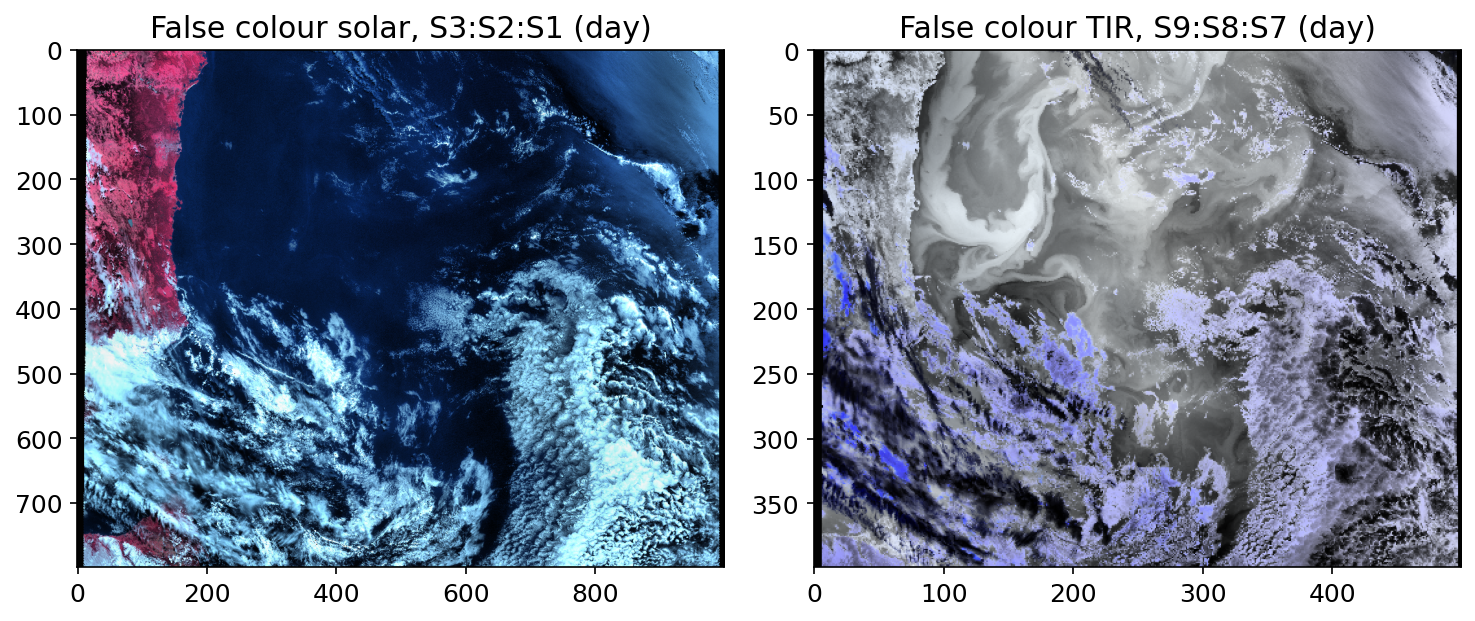

In [336]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8), dpi=150)

axs[0].imshow(rgb_fsc_321); axs[0].title.set_text('False colour solar, S3:S2:S1 (day)')
axs[1].imshow(rgb_tir_day); axs[1].title.set_text('False colour TIR, S9:S8:S7 (day)')

plt.tight_layout()

# Splitting channels

While we can plot night-time imagery from SLSTR by mapping S7/S8/S9 to the RGB channels, more often that not it is helpful to use a single channel and "split" it into two colour palettes to differentiate between land and ocean. We can apply this technique to any IR channel, but in the examples below we will use S9, the 12 $\mu$m IR band.

We will use the level-1 flags to separate the land, cloud and ocean. We will mask out the cloud, map the land in a "red" palette and the ocean in a "blue" palette.

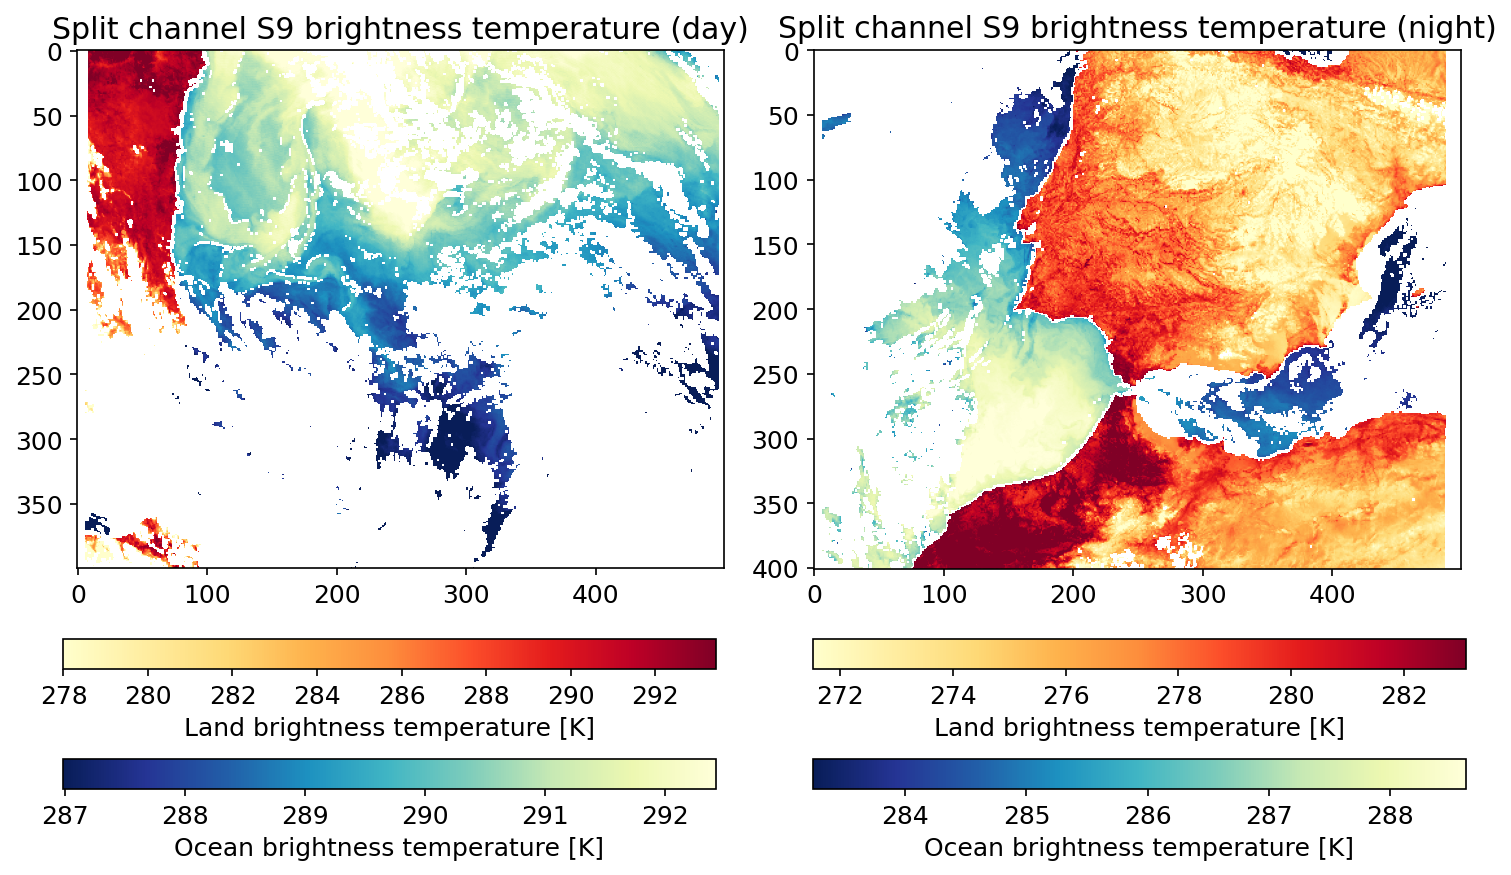

In [344]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8), dpi=150)

for ax, tod, offset in zip([axs[0], axs[1]], ["day", "night"], [0.05, 0.55]):
    
    split_land = np.array(band_dict[tod]['S9_BT_in'])
    split_ocean = np.array(band_dict[tod]['S9_BT_in'])

    split_land[band_dict[tod]['flags_in_cloud'] == 1] = np.nan
    split_land[band_dict[tod]['flags_in_land'] == 0] = np.nan
    split_ocean[band_dict[tod]['flags_in_cloud'] == 1] = np.nan
    split_ocean[band_dict[tod]['flags_in_ocean'] == 0] = np.nan

    if tod == "night":
        split_land = split_land[::-1,::-1]
        split_ocean = split_ocean[::-1,::-1]
        
    c1 = ax.imshow(split_land, cmap=plt.cm.YlOrRd, 
                       vmin=np.nanpercentile(split_land, 5),
                       vmax=np.nanpercentile(split_land, 95))
    c2 = ax.imshow(split_ocean, cmap=plt.cm.YlGnBu_r,
                       vmin=np.nanpercentile(split_ocean, 5),
                       vmax=np.nanpercentile(split_ocean, 95))

    ax.title.set_text(f'Split channel S9 brightness temperature ({tod})')

    cb_ax1 = fig.add_axes([offset, 0.2, 0.435, 0.025])
    fig.colorbar(c1, cax=cb_ax1, orientation="horizontal", label='Land brightness temperature [K]')
    cb_ax2 = fig.add_axes([offset, 0.1, 0.435, 0.025])
    fig.colorbar(c2, cax=cb_ax2, orientation="horizontal", label='Ocean brightness temperature [K]')

plt.tight_layout()

It is important to note here, that even though we have used two palettes, they often overlap. At night, the land radiates away its temperature much more readily than the ocean, cooling quicker. Consequently, the land (despite being mapped to red!) is cooler than the ocean (see the colour bar ranges on the right hand panels). However, during the day, the brightness temperature of the land and ocean are often in the same range, and so there is significant, or even entire, overlap between the two colour scales. 

<div class="alert alert-info" role="alert">

## <a id='section5'></a>5. Mapping RGBs
[Back to top](#TOC_TOP)

</div>

So far we have only shown images displayed against pixel coordinates (rows & columns). If we want to display this on geographical coordinates we need to use our longitude and latitude variables. The SLSTR level-1b and level-2 grids are "curvilinear", so our longitude and latitude coordinates are both 2-dimensional arrays. The most convenient way to plot this in python is to use the matplotlib `pcolormesh` routine, and to map each pixel to an RGB colour.

In [275]:
geo_file = os.path.join(SAFE_directories[1],'geodetic_in.nc')
geo_vars = xr.open_dataset(geo_file)
lon_day = geo_vars.longitude_in.data[::grid_reduce,::grid_reduce]
lat_day = geo_vars.latitude_in.data[::grid_reduce,::grid_reduce]
geo_vars.close()

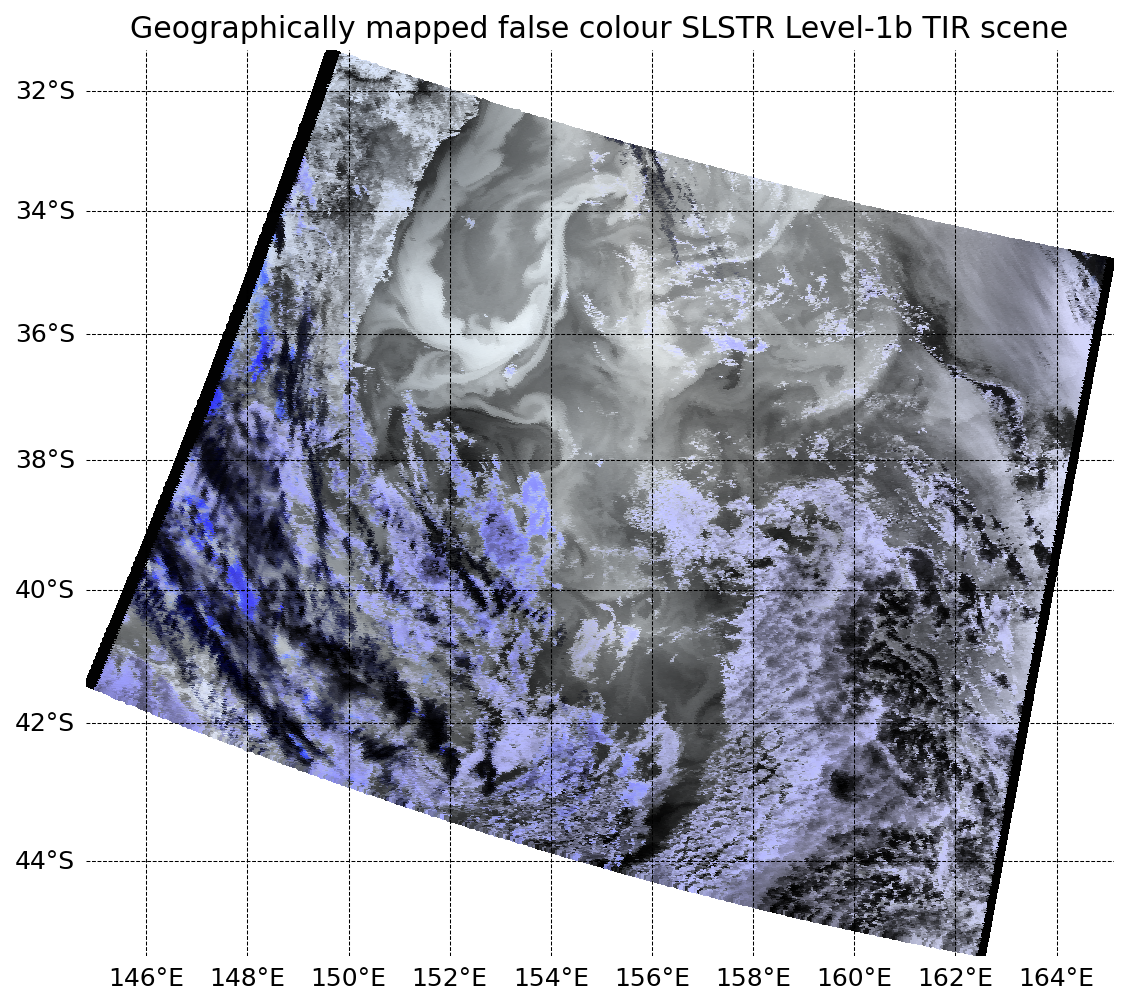

In [328]:
fig = plt.figure(figsize=(10, 8), dpi=150)
m = plt.subplot(projection=ccrs.Mercator())

# make the colour map
colorArray = np.array(rgb_tir_day)
colorTuple = colorArray.reshape((colorArray.shape[0] * colorArray.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

# make the map
m.pcolormesh(lon_day, lat_day, lon_day, color=colorTuple, edgecolors=None, transform=ccrs.PlateCarree())

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='k', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 2))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 2))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set(facecolor = "1.0")
m.axis('off')

plt.title('Geographically mapped false colour SLSTR Level-1b TIR scene')
plt.savefig('1_4_SLSTR_TIR_RGB.png', bbox_inches='tight')
plt.show()

Due to the bands we have selected, and the fact that this is a level-1 product, the image above is quite difficult to interpret. However with some understanding of the synoptic scale and typical patterns of different ocean and atmosphere features, we can see that the TIR bands can reveal variability associated with sea and land surfaces, and clouds/the atmosphere. This is the fundamental basis of how we can use this data for a diverse range of applications.

<div class="alert alert-danger" role="alert">

## <a id='section5'></a>5. Applying your knowledge
[Back to top](#TOC_TOP)

</div>

<div class="alert alert-block alert-warning">

### Challenge:

Try using the routines provided to create a geographically mapped scene, that highlights the dynamic oceanographic features in the TIR channels in our night-time scene. <br> <br>
    - hint: the bands you need are in band_dict['night'] <br>
 <div>

In [11]:
# Enter your solution here


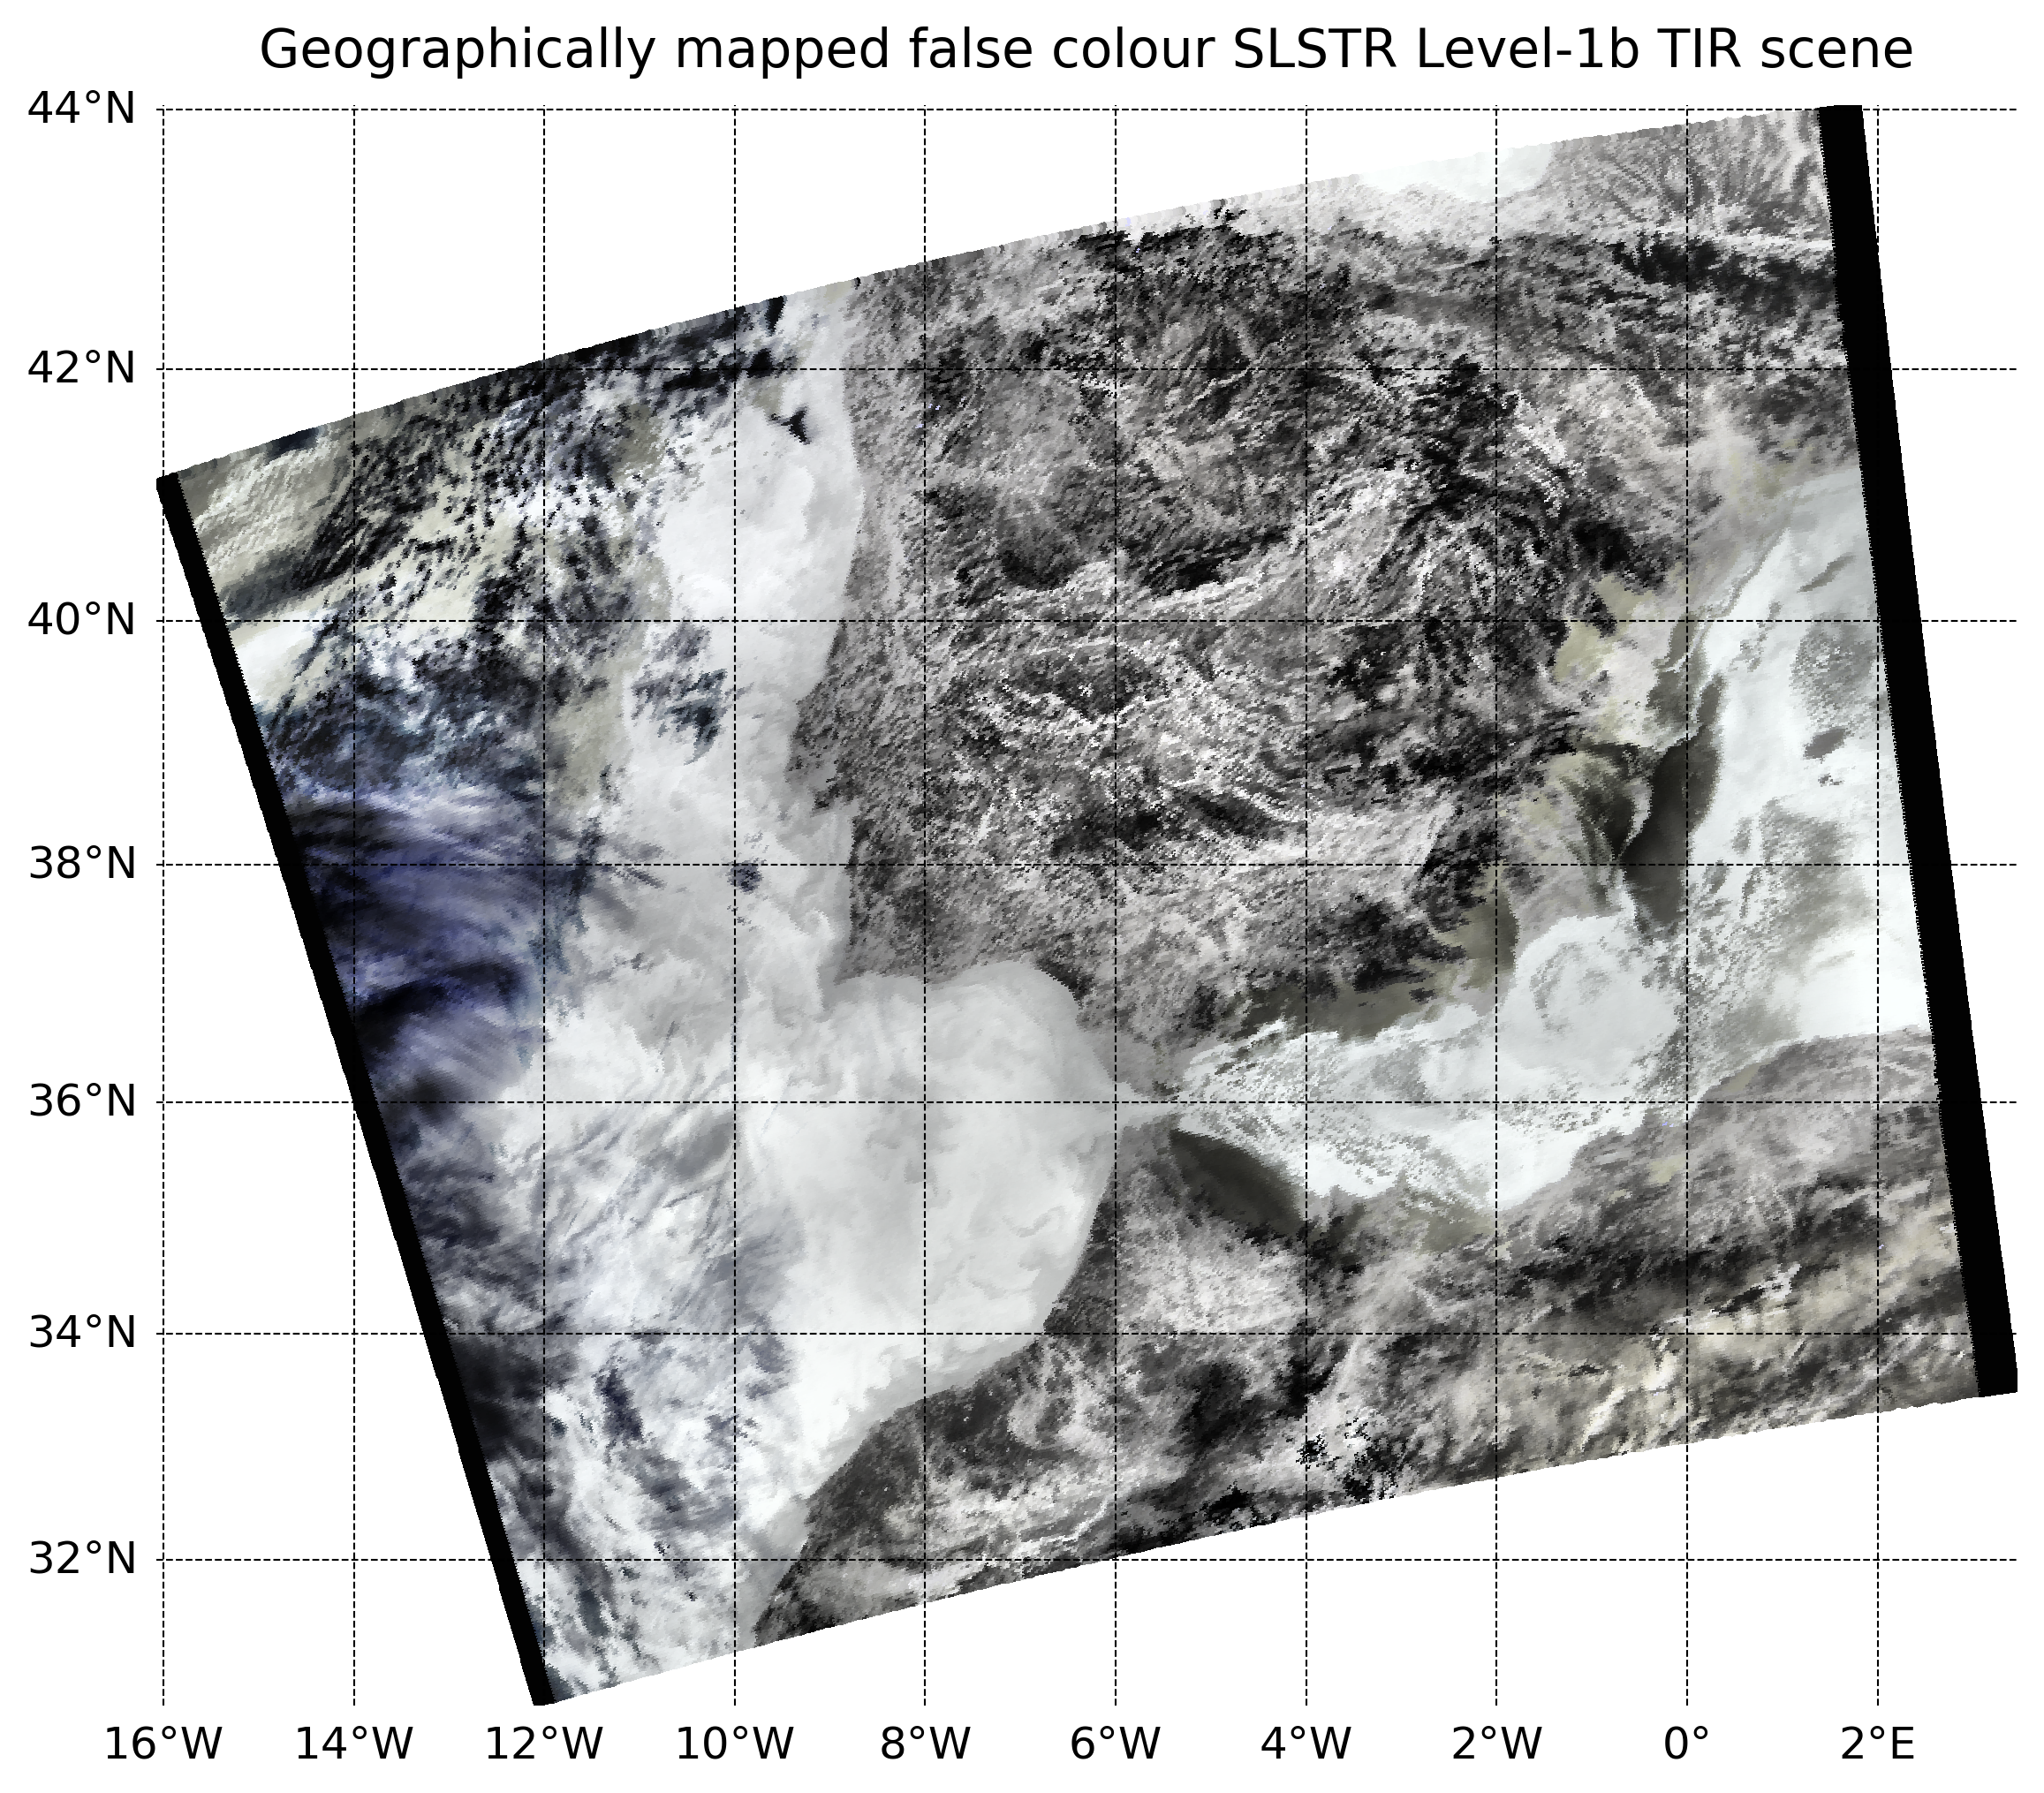

In [329]:
# An example! Palette is S9-S8:S8:S7
geo_file = os.path.join(SAFE_directories[0],'geodetic_in.nc')
geo_vars = xr.open_dataset(geo_file)
lon_night = geo_vars.longitude_in.data[::grid_reduce,::grid_reduce]
lat_night = geo_vars.latitude_in.data[::grid_reduce,::grid_reduce]
geo_vars.close()

tod = "night"
red_recipe = np.array(band_dict[tod]['S9_BT_in'])
green_recipe = np.array(band_dict[tod]['S8_BT_in'])
blue_recipe = np.array(band_dict[tod]['S7_BT_in'])

rgb_tir_night = np.dstack((red_recipe, green_recipe, blue_recipe))
rgb_tir_night = eumartools.normalise_image(rgb_tir_night, unhitch=False)
rgb_tir_night = eumartools.histogram_image(rgb_tir_night, nbins=2098)

# make the plot
fig = plt.figure(figsize=(10, 8), dpi=300)
m = plt.subplot(projection=ccrs.Mercator())

# make the colour map
colorArray = np.array(rgb_tir_night)
colorTuple = colorArray.reshape((colorArray.shape[0] * colorArray.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

# make the map
m.pcolormesh(lon_night, lat_night, lon_night, color=colorTuple, edgecolors=None, transform=ccrs.PlateCarree())

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='k', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 2))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 2))
g1.xlabels_top = False
g1.ylabels_right = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set(facecolor = "1.0")
m.axis('off')

plt.title('Geographically mapped false colour SLSTR Level-1b TIR scene')

plt.show()

The image above shows patterns in the TIR data that are a mix of the signals from the atmosphere, clouds, and the sea surface temperature. In the following notebooks you can learn more about how these signals are separated and how sea surface temperature can be derived from the TIR data. 

<hr>

### What to try next?

* Try choose your own SLSTR Level-1 product and create your own RGB image.

<hr>
<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_3_SLSTR_coverage.ipynb"><< Determining SLSTR product coverage</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_5_SLSTR_radiance_BT_spectra.ipynb">SLSTR radiance and brightness temperature spectra >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>